In [13]:
## Import libraries and useful functions
suppressMessages({
  library(ggplot2)
  library(terra)
  library(leaflet)
  library(tidyr)
  library(dplyr)
  library(progress)
  library(sf)
})

source("../scripts/utils.R")
source("../scripts/visualize.R")

In [16]:
## Set paths and load data
# Input NVDI basemaps stored in country folder. 
# Area of Interest (AoI) files in AoI folder

country_name <- "Zambia"
data_type <- "NDVI"
land_use_src <- "S2_10m_LULC_2023"
resolution <- 100 # in meters
data_path <- paste0("../data/", data_type, "/", country_name, "/", resolution, "m_resolution/")
lulc_path <- paste0("../data/LandUse/", country_name, "/", land_use_src, "/")
aoi_path <- "../data/AoI/"

test_year <- 2024


In [17]:
## Create lists with relevant filenames.
## Extract date, and order accordingly

# NDVI filenames
ndvi_files <- get_filenames(filepath = data_path, data_type = data_type, 
                            file_extension = ".tif", country_name = country_name)

# AoI filenames
aoi_files <- get_filenames(filepath = aoi_path, data_type = "AoI", 
                           file_extension = ".geojson", country_name = country_name)

# LULC filenames
lulc_files <- get_filenames(filepath = lulc_path, data_type = "LandUseVector", 
                            file_extension = ".geojson", country_name = country_name)

# Extract the date part from the filenames using a regular expression
# Assumes only year and month in filename
dates <- extract_dates(file_list = ndvi_files)

# Convert extracted date strings to date objects
# sorting files based on the date objects (ascending)
ndvi_files <- order_by_date(file_list = ndvi_files, dates = dates, decreasing = FALSE)


Loading NDVI data for Zambia 

Loading AoI data for Zambia 

Loading LandUseVector data for Zambia 

Found data for 72 months, from 2019-01 to 2024-12 


In [18]:
## Load raster and vector objects

# load input Area of Interest (AoI) to later mask data
aoi_proj <- get_aoi_vector(aoi_files = aoi_files, aoi_path = aoi_path,
                           projection = "EPSG:4326")

ndvi_msk <- get_ndvi_raster(ndvi_files = ndvi_files, data_path = data_path,
                            projection = "EPSG:4326", dates = dates,
                            aoi_proj = aoi_proj)


Reading layer `AoI_Mponda' from data source 
  `C:\SD\correlaid_sensingclues\environmental-time-series\data\AoI\AoI_Zambia_By_Life_Connected.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 26.77027 ymin: -15.1321 xmax: 26.92342 ymax: -14.85555
Geodetic CRS:  WGS 84


In [19]:
# Initialize empty data frame to hold all results
all_test_ndvi_summary <- data.frame()
all_train_ndvi_summary <- data.frame()

land_use_types <- c("Crops", "Rangeland", "Trees")

# Initialize progress bar
# TODO: Fix progress bar to show progress
pb <- progress_bar$new(total = length(lulc_files), format = "[:bar] :percent :elapsedfull")

for (land_cover_vector in lulc_files) {
    land_use = get_aoi_vector(aoi_files = land_cover_vector, aoi_path = lulc_path,
                              projection = "EPSG:4326")

    # Extract land use type from file name (assuming file names follow a pattern)
    land_use_type <- gsub(pattern = paste0(country_name, "_|_[0-9]{4}|\\.geojson$"), replacement = "", basename(land_cover_vector))
    
    # Mask the raster with the land use polygon
    ndvi_land_use <- mask(ndvi_msk, land_use)

    ndvi_df <- get_ndvi_df(ndvi_rast = ndvi_land_use, dates = dates)

    ## now split df into train and test data
    # train year data
    train_ndvi_df <- ndvi_df[ndvi_df$Year != test_year,]
    # test year data
    test_ndvi_df <- ndvi_df[ndvi_df$Year == test_year,]

    # drop missing values
    train_ndvi_df <- na.omit(train_ndvi_df)
    test_ndvi_df <- na.omit(test_ndvi_df)

    ## Compute mean, SD, and confidence intervals
    # train data
    train_ndvi_summary <- get_summary_ndvi_df(ndvi_df = train_ndvi_df)
    # test data
    test_ndvi_summary <- get_summary_ndvi_df(ndvi_df = test_ndvi_df)
    
    # Filter for desired land use types if provided
    if (is.null(land_use_types) || land_use_type %in% land_use_types) {
        train_ndvi_summary$land_use <- land_use_type
        test_ndvi_summary$land_use <- land_use_type
    
        # Append to the overall data frames
        all_train_ndvi_summary <- bind_rows(all_train_ndvi_summary, train_ndvi_summary)
        all_test_ndvi_summary <- bind_rows(all_test_ndvi_summary, test_ndvi_summary)
    }

    # Update progress bar
    pb$tick()

}

# Convert the sf object to a data.frame to avoid issues with the geometry column
all_train_ndvi_summary <- as.data.frame(all_train_ndvi_summary)
all_test_ndvi_summary <- as.data.frame(all_test_ndvi_summary)

Reading layer `Zambia_Bare_ground' from data source 
  `C:\SD\correlaid_sensingclues\environmental-time-series\data\LandUse\Zambia\S2_10m_LULC_2023\Zambia_Bare_ground_2023.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 0 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 489750 ymin: 8333500 xmax: 489950 ymax: 8333820
Projected CRS: WGS 84 / UTM zone 35S


`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


Reading layer `Zambia_Built_Area' from data source 
  `C:\SD\correlaid_sensingclues\environmental-time-series\data\LandUse\Zambia\S2_10m_LULC_2023\Zambia_Built_Area_2023.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 0 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 475940 ymin: 8327510 xmax: 490280 ymax: 8356980
Projected CRS: WGS 84 / UTM zone 35S


`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


Reading layer `Zambia_Crops' from data source 
  `C:\SD\correlaid_sensingclues\environmental-time-series\data\LandUse\Zambia\S2_10m_LULC_2023\Zambia_Crops_2023.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 0 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 475290 ymin: 8327060 xmax: 490810 ymax: 8357640
Projected CRS: WGS 84 / UTM zone 35S


`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


Reading layer `Zambia_Flooded_vegetation' from data source 
  `C:\SD\correlaid_sensingclues\environmental-time-series\data\LandUse\Zambia\S2_10m_LULC_2023\Zambia_Flooded_vegetation_2023.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 0 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 487840 ymin: 8328220 xmax: 487960 ymax: 8328330
Projected CRS: WGS 84 / UTM zone 35S


`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


Reading layer `Zambia_Rangeland' from data source 
  `C:\SD\correlaid_sensingclues\environmental-time-series\data\LandUse\Zambia\S2_10m_LULC_2023\Zambia_Rangeland_2023.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 0 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 475290 ymin: 8327100 xmax: 491770 ymax: 8357640
Projected CRS: WGS 84 / UTM zone 35S


`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


Reading layer `Zambia_Trees' from data source 
  `C:\SD\correlaid_sensingclues\environmental-time-series\data\LandUse\Zambia\S2_10m_LULC_2023\Zambia_Trees_2023.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 0 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 475290 ymin: 8327070 xmax: 491770 ymax: 8357520
Projected CRS: WGS 84 / UTM zone 35S


`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


Reading layer `Zambia_Water' from data source 
  `C:\SD\correlaid_sensingclues\environmental-time-series\data\LandUse\Zambia\S2_10m_LULC_2023\Zambia_Water_2023.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 0 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 477090 ymin: 8328060 xmax: 490140 ymax: 8339900
Projected CRS: WGS 84 / UTM zone 35S


`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


In [20]:
all_train_ndvi_summary

Month,mean_val,lower_ci,upper_ci,land_use
<chr>,<dbl>,<dbl>,<dbl>,<chr>
01,0.5208781,0.4774284,0.5643278,Crops
02,0.6597130,0.6394347,0.6799913,Crops
03,0.5903488,0.5489185,0.6317790,Crops
04,0.5605843,0.5084774,0.6126911,Crops
05,0.4071736,0.3805311,0.4338160,Crops
06,0.3276258,0.3114147,0.3438370,Crops
07,0.2561210,0.2439058,0.2683361,Crops
08,0.2018713,0.1821971,0.2215455,Crops
09,0.2038976,0.1915033,0.2162919,Crops


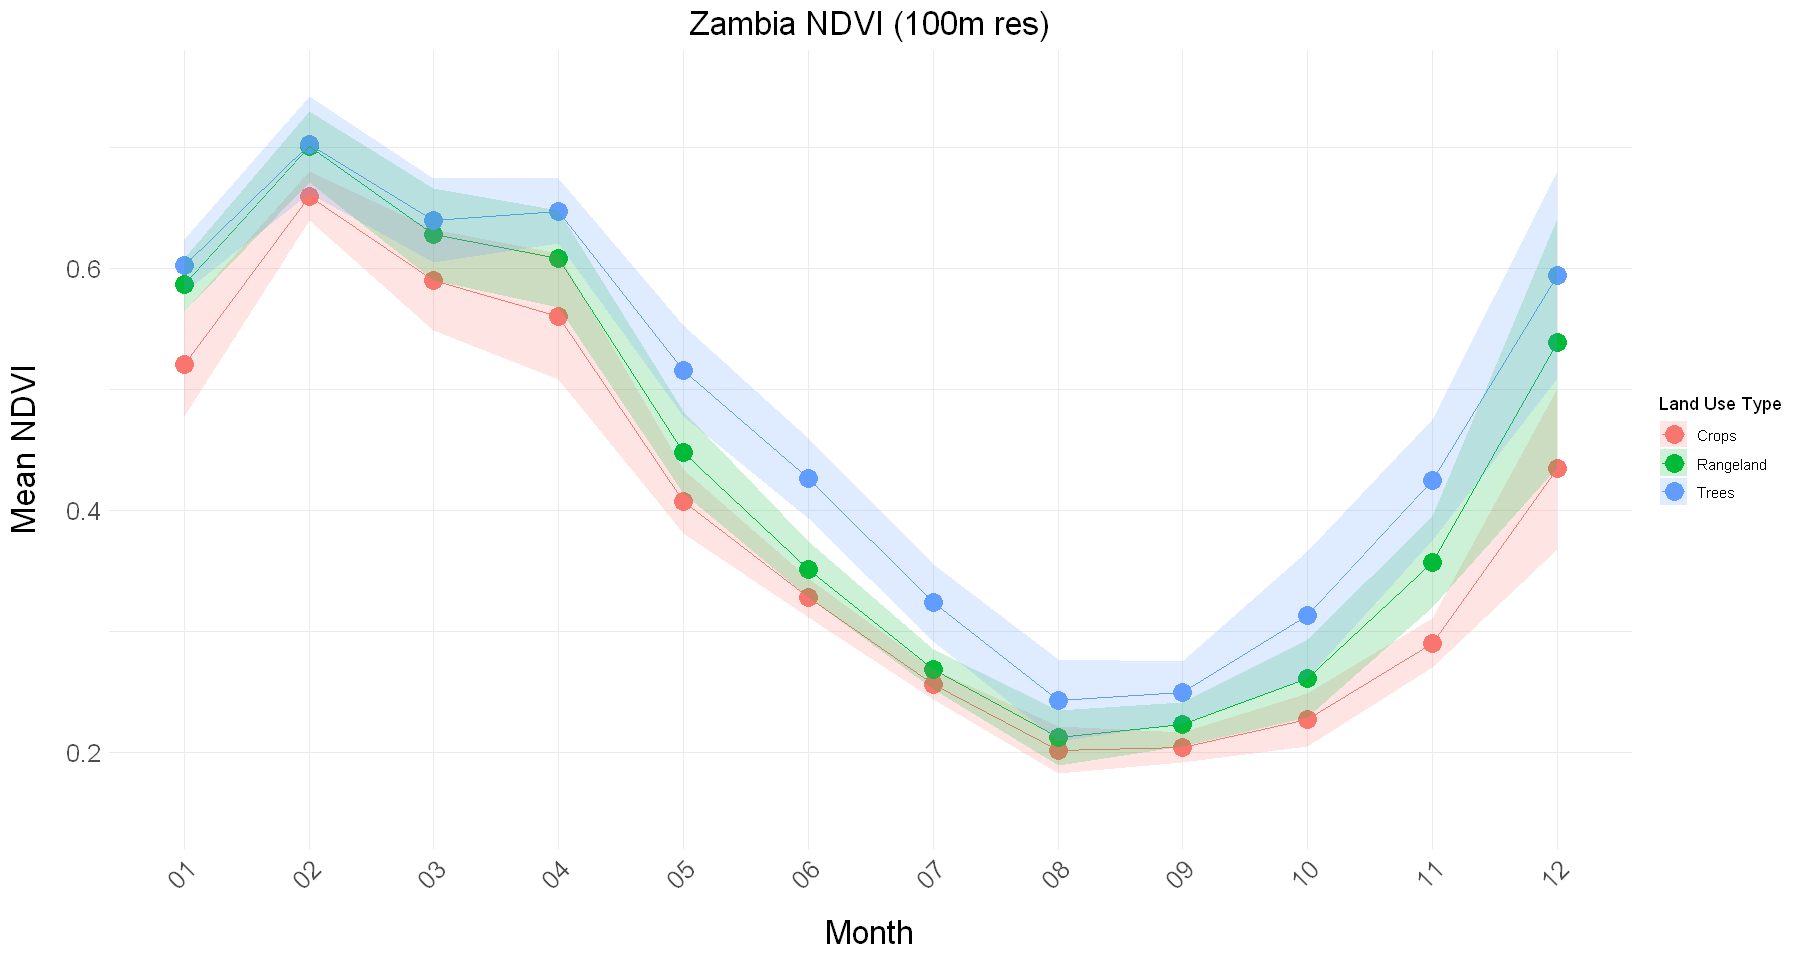

In [21]:
## Inspect distribution of NDVI values throughout the year.
ndvi_ts_plot <- plot_grouped_training_ndvi_timeseries(train_data_grouped = all_train_ndvi_summary, 
                                        country_name = country_name, 
                                        resolution = resolution,
                                        plot_width = 15, 
                                        plot_height = 8,
                                        ylim_range = c(0.15, 0.75),
                                        save_path = NULL, 
                                        filename = paste0(country_name, "_", 
                                                          resolution, "m_",
                                                          "NDVI_grouped_timeseries.png")
                                        )
ndvi_ts_plot

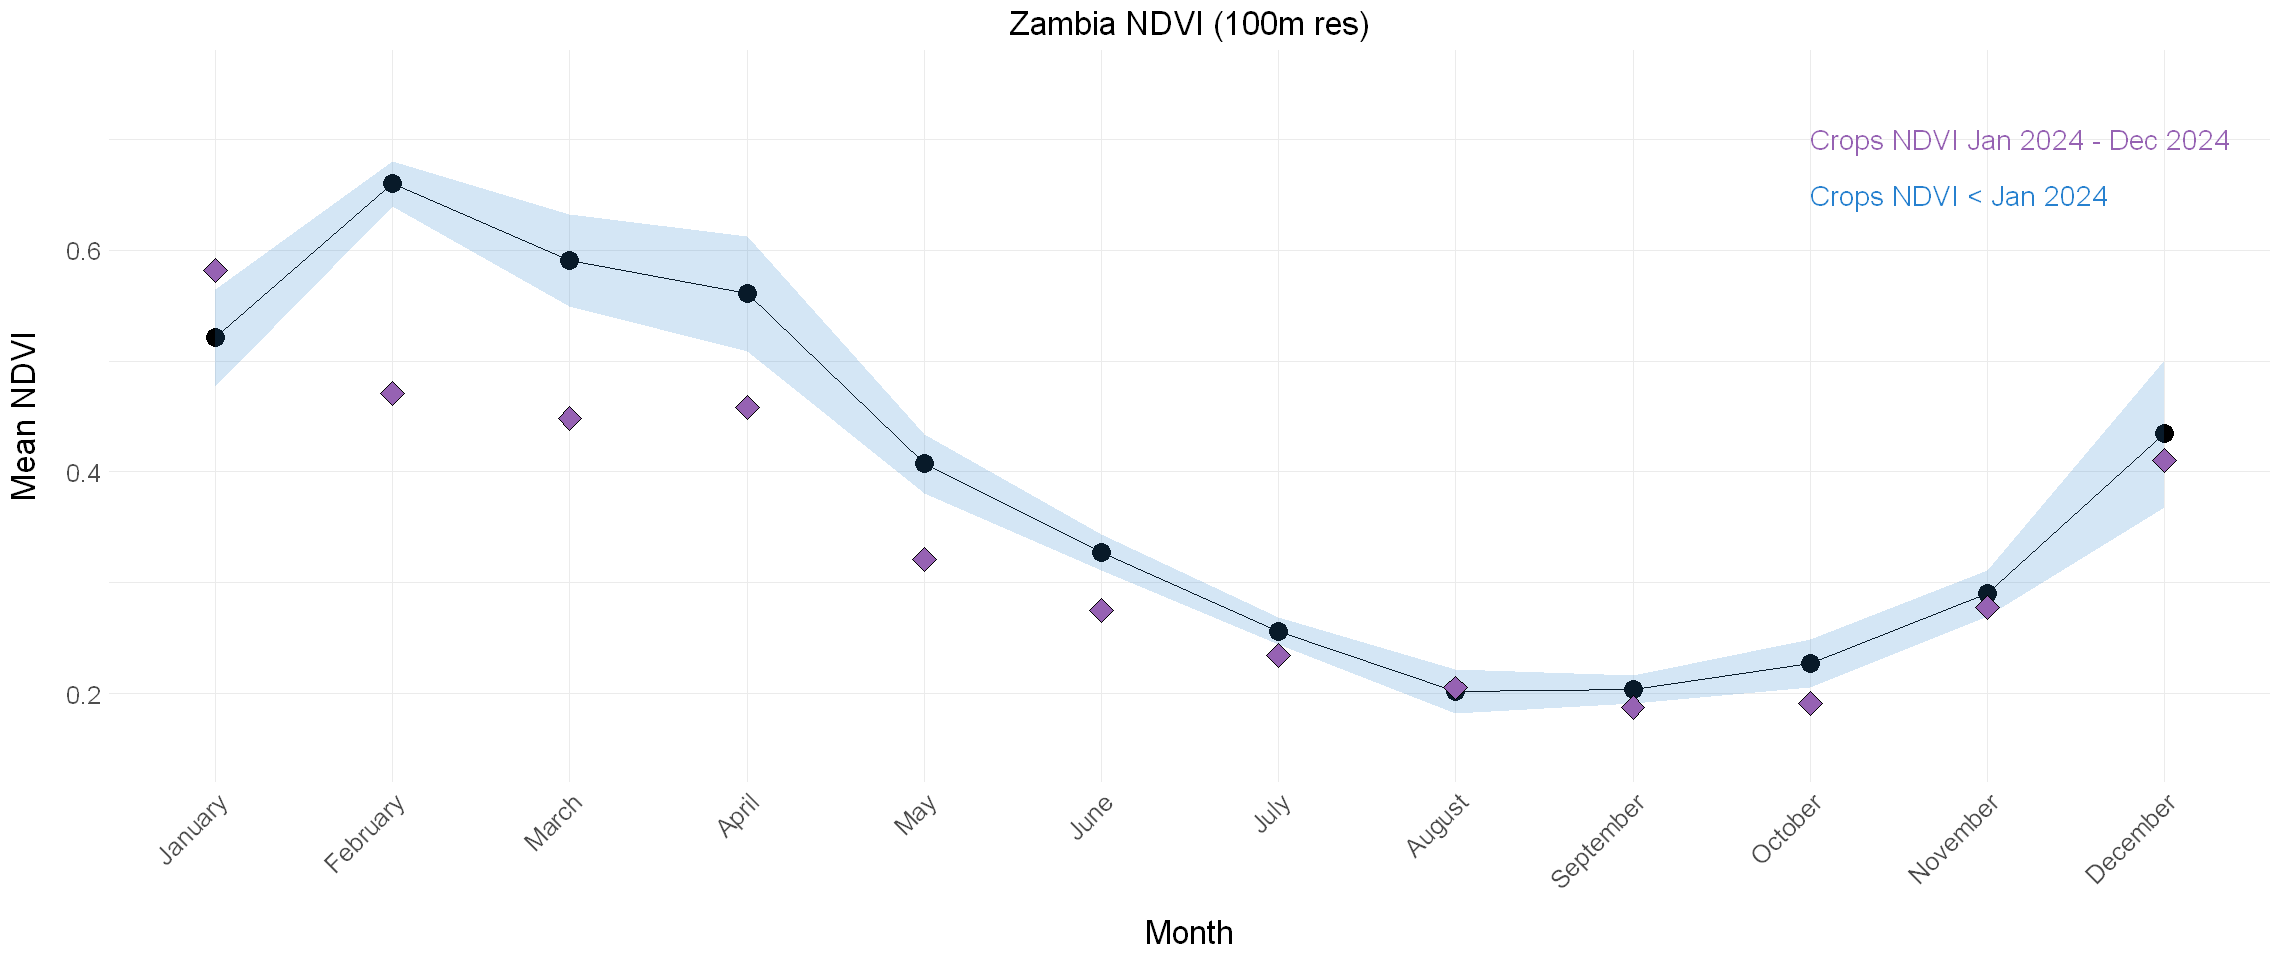

In [30]:
# Plot just one land use type, train and test

# filter train and test summaries by one land use type

## define end and start date for test data
end_year <- 2024
end_month <- 12
end_date <- as.Date(paste(end_year, end_month, 1, sep="-"))
start_date <- seq(end_date, length = 2, by = "-11 months")[2]


land_use_type <- "Crops"

train_land_use_summary <- all_train_ndvi_summary %>% filter(land_use == land_use_type)
test_land_use_summary <- all_test_ndvi_summary %>% filter(land_use == land_use_type)

ndvi_ts_plot <- plot_ndvi_timeseries(   train_data = train_land_use_summary, 
                                        test_data = test_land_use_summary,
                                        country_name = country_name, 
                                        resolution = resolution,
                                        plot_width = 19, 
                                        plot_height = 8,
                                        ylim_range = c(0.15, 0.75),
                                        test_start_date = start_date, test_end_date = end_date,
                                        label_test = paste0(land_use_type, " NDVI ", paste(format(c(start_date, end_date), "%b %Y"),collapse=" - ") ),
                                        label_train = paste0(land_use_type, " NDVI < ", format(start_date, "%b %Y") ),
                                        save_path = NULL, 
                                        filename = paste0(country_name, "_", 
                                                          resolution, "m_",
                                                          "NDVI_timeseries.png")
                                        )
ndvi_ts_plot

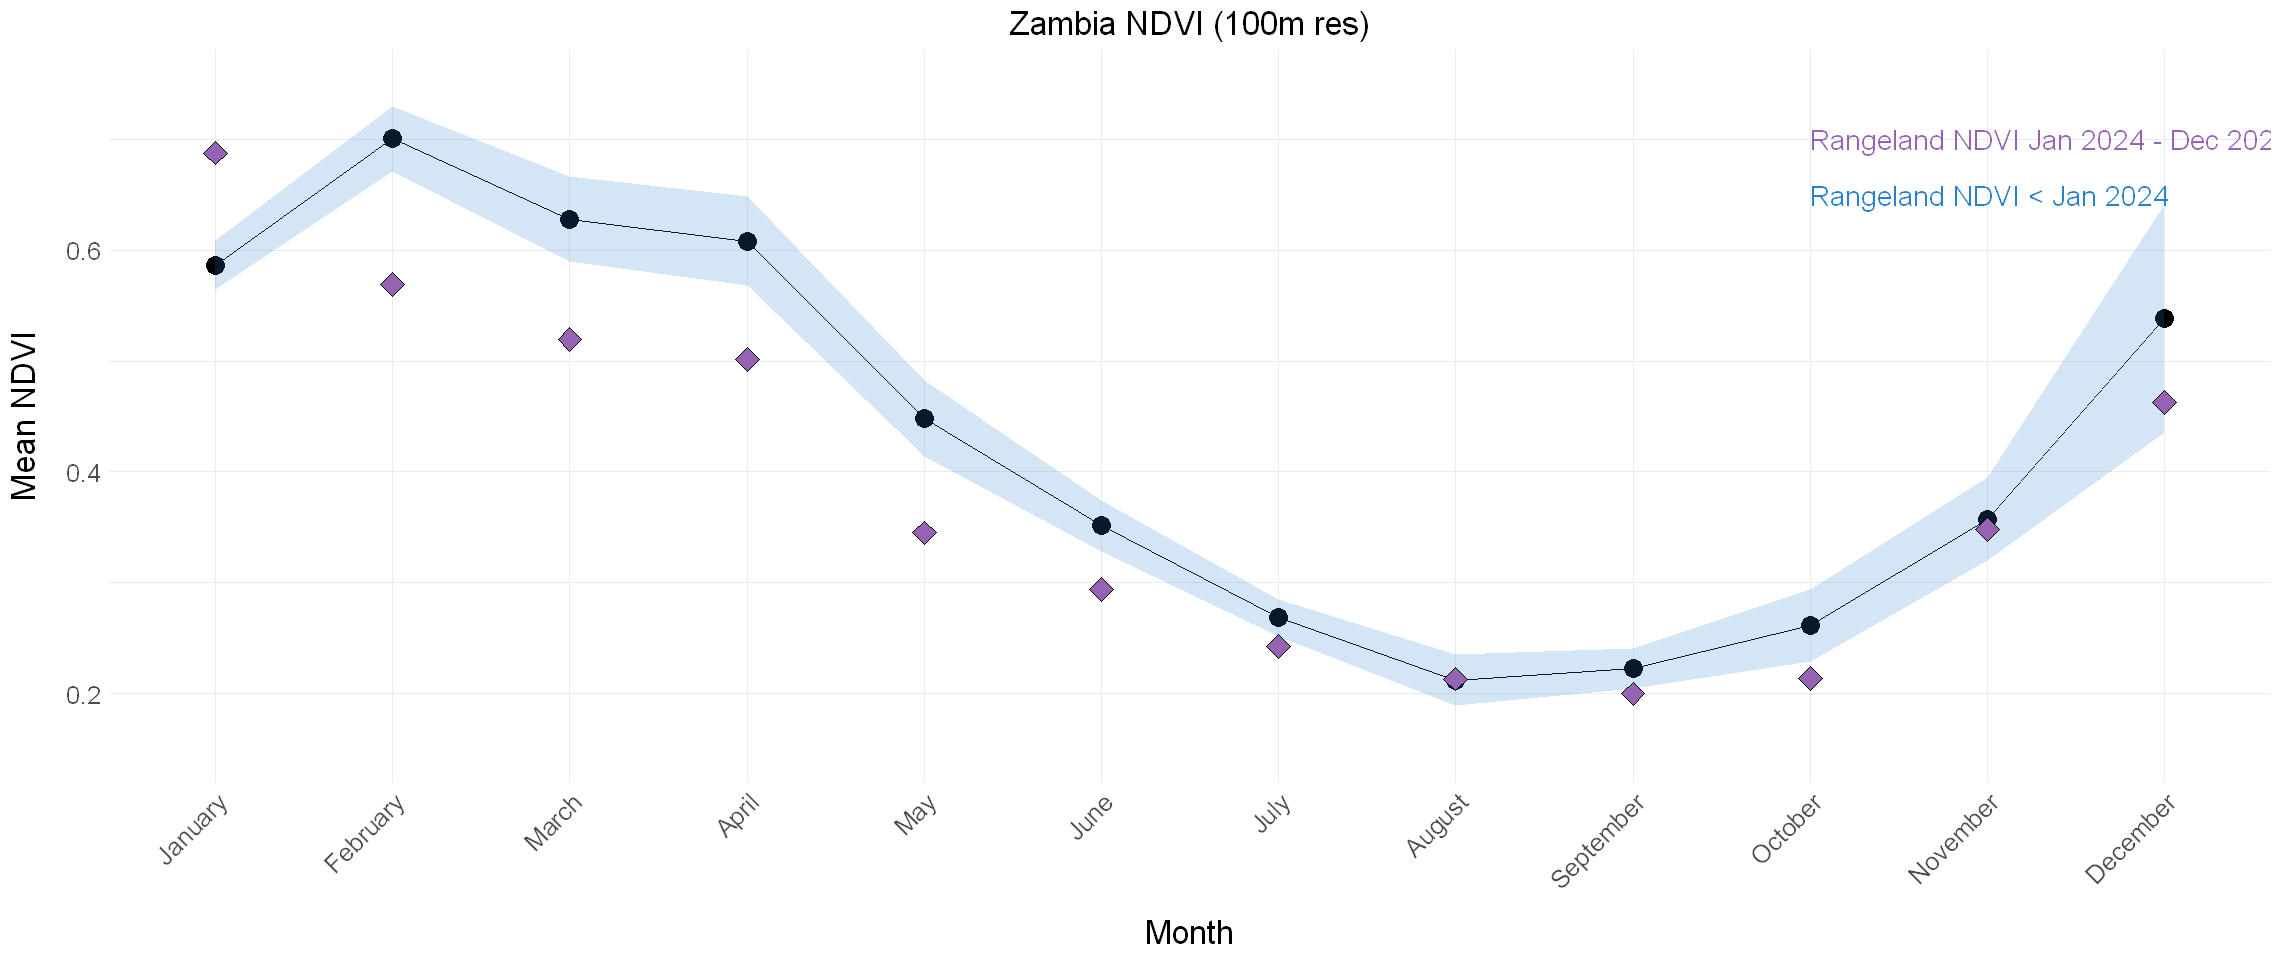

In [32]:
# Plot just one land use type, train and test

# filter train and test summaries by one land use type

land_use_type <- "Rangeland"

train_land_use_summary <- all_train_ndvi_summary %>% filter(land_use == land_use_type)
test_land_use_summary <- all_test_ndvi_summary %>% filter(land_use == land_use_type)

ndvi_ts_plot <- plot_ndvi_timeseries(   train_data = train_land_use_summary, 
                                        test_data = test_land_use_summary,
                                        country_name = country_name, 
                                        resolution = resolution,
                                        plot_width = 19, 
                                        plot_height = 8,
                                        ylim_range = c(0.15, 0.75),
                                        test_start_date = start_date, test_end_date = end_date,
                                        label_test = paste0(land_use_type, " NDVI ", paste(format(c(start_date, end_date), "%b %Y"),collapse=" - ") ),
                                        label_train = paste0(land_use_type, " NDVI < ", format(start_date, "%b %Y") ),
                                        save_path = NULL, 
                                        filename = paste0(country_name, "_", 
                                                          resolution, "m_",
                                                          "NDVI_timeseries.png")
                                        )

ndvi_ts_plot

## Plotting land cover

In [15]:
# Example usage
folder_path <- "../data/LandUse/Zambia/S2_10m_LULC_2023"
map <- plot_geojsons_from_a_folder(folder_path)

# Save the map as an HTML file
saveWidget(map, "../figures/zambia_landuse.html", selfcontained = TRUE)

Reading layer `Zambia_Bare_ground' from data source 
  `C:\SD\correlaid_sensingclues\environmental-time-series\data\LandUse\Zambia\S2_10m_LULC_2023\Zambia_Bare_ground_2023.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 0 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 489750 ymin: 8333500 xmax: 489950 ymax: 8333820
Projected CRS: WGS 84 / UTM zone 35S
Reading layer `Zambia_Built_Area' from data source 
  `C:\SD\correlaid_sensingclues\environmental-time-series\data\LandUse\Zambia\S2_10m_LULC_2023\Zambia_Built_Area_2023.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 0 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 475940 ymin: 8327510 xmax: 490280 ymax: 8356980
Projected CRS: WGS 84 / UTM zone 35S
Reading layer `Zambia_Crops' from data source 
  `C:\SD\correlaid_sensingclues\environmental-time-series\data\LandUse\Zambia\S2_10m_LULC_2023\Zambia_Crops_2023.geojson' 
  usin